In [1]:
print(1)


1


In [ ]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import gc
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from config import *
import re
import numpy as np

### Data set-up

In [3]:
def get_sara():
    return ir_datasets.load('sara')


def dataset_to_df(sara_dataset):
    doc_ids = []
    doc_text = []
    doc_sens = []
    for doc in sara_dataset.docs_iter():
        doc_ids.append(doc.doc_id)
        doc_text.append(doc.text)
        doc_sens.append(doc.sensitivity)

    sara_dict = {'doc_id':doc_ids, 'text':doc_text, 'sensitivity':doc_sens}
    df = pd.DataFrame.from_dict(sara_dict)
    return df


def get_sample_n(data, n):
    return data.sample(n=n, random_state=1)

def get_sample_frac(data, frac):
    return data.sample(frac=frac, random_state=1)

### Pre-processing

Preprocessing 1 - Separating replies using Original Message and Forwarded tags.

In [4]:
def proc1(dataset):
    def get_orig(message, find_orig_message):
        #line_start = message.rfind('\n', 0, find_orig_message)
        line_start = find_orig_message
        base_message = message[:line_start]
        line_end = find_orig_message + 5 #message.find('\n', find_orig_message)
        orig_message = message[line_end:]
        return base_message, orig_message

    def get_separate_messages(message):
        payload = message.split('\r\n\r\n')[1]
        separate_messages = []

        find_fwd_message = payload.find('\n----- Forw')
        find_orig_message = payload.find('-----Original Message-')
        
        n = payload
        while (find_fwd_message > 0 or find_orig_message > 0):
            if (find_fwd_message > 0 and find_orig_message > 0):
                if find_fwd_message < find_orig_message:
                    b, n = get_orig(n, find_fwd_message)
                else:
                    b, n = get_orig(n, find_orig_message)
            elif (find_fwd_message > 0 and find_orig_message < 0):
                b, n = get_orig(n, find_fwd_message)
            else:
                b, n = get_orig(n, find_orig_message)
            
            find_fwd_message = n.find('\n----- Forw')
            find_orig_message = n.find('-----Original Message-')

            b = re.sub(r'\s+', ' ', b)
            separate_messages.append(b)

        n = re.sub(r'\s+', ' ', n)
        separate_messages.append(n)

        return separate_messages

    def preprocessing_dataframe(testing_sample):
        ids = []
        texts = []
        sens = []
        preproc = {}

        for s in testing_sample.iterrows():
            separate_messages = get_separate_messages(s[1].text)

            if len(separate_messages) == 1:
                ids.append(s[1].doc_id)
                texts.append(separate_messages[0])
                sens.append(s[1].sensitivity)
            else:
                for i, m in enumerate(separate_messages):
                    id_part = s[1].doc_id + '_' + str(i)
                    ids.append(id_part)
                    texts.append(m)
                    sens.append(s[1].sensitivity)

        preproc['doc_id'] = ids
        preproc['text'] = texts
        preproc['sensitivity'] = sens
        return preproc

    def get_preprocessed_sara_replies(dataset):
        preproc = preprocessing_dataframe(dataset)
        preproc_df = pd.DataFrame.from_dict(preproc)
        return preproc_df

    return get_preprocessed_sara_replies(dataset)


Preprocessing 2 - Separating paragraphs. Each paragraph is treated as a separate document. 
- Where double newline exists. Also found some areas with '\n whitespace \n' that has been replaced.
- As reply headers cannot be cleaned easily, the paragraph with To for example could be removed as this should just be the header. Likewise with empty documents. 
- The smallest ~1000 documents have length less than 20: these are usually letters/punctuation/name sign offs - these are less informative or useful in identifying the sensitivity of the information, so have been removed for simplicity in this preprocessing strategy.

In [5]:
def proc2(dataset):
    def process_text(input_text):
        clean = input_text
        clean = re.sub(r'=20', ' ', clean)
        clean = re.sub(r'=09', ' ', clean)
        # Also > Whitespace1+ > 
        clean = re.sub(r'\n\>', '\n', clean)
        clean = re.sub(r'\n\n\t', '\n', clean)
        # Replace whitespace between two newline characters with a single newline
        #cleaned_text = re.sub(r'\n\s*\n', '\n\n', input_text)
        #clean = re.sub(r'\n \n', '\n\n', clean)
        clean = re.sub(r'\n \n', '\n', clean)
        return clean

    def get_separate_paras(doc):
        paras = []
        payload = doc.split('\r\n\r\n')[1]
        payload = process_text(payload)
        split_load = payload.split('\n\n')
        for m in split_load:
            #if 'Subject:' in t:
            #    continue
            if 'To:' in m or 'From:' in m or 'mailto' in m or m == '':
                continue
            if len(m) < 2:
                continue
            if len(m) < 20:
                continue
            
            m = re.sub(r'\s+', ' ', m)
            paras.append(m)
        return paras

    def preproc(sample):
        sep_docs = []
        sep_docs_ids = []
        sep_docs_sens = []
        i = 0
        for s in sample.iterrows():

            separate_messages = get_separate_paras(s[1].text)
            for i, m in enumerate(separate_messages):
                id_part = s[1].doc_id + '_' + str(i)
                sep_docs_ids.append(id_part)
                sep_docs.append(m)
                sep_docs_sens.append(s[1].sensitivity)

        preproc = {}
        preproc['doc_id'] = sep_docs_ids
        preproc['text'] = sep_docs
        preproc['sensitivity'] = sep_docs_sens
        preproc_df = pd.DataFrame.from_dict(preproc)
        return preproc_df

    def get_preprocessed_sara_paras(dataset):
        preproc_data = preproc(dataset)
        preproc_df = pd.DataFrame.from_dict(preproc_data)
        return preproc_df

    return get_preprocessed_sara_paras(dataset)

Preprocessing 3

In [6]:
def proc3(dataset):
    def get_orig(message, find_orig_message):
        #line_start = message.rfind('\n', 0, find_orig_message)
        line_start = find_orig_message
        base_message = message[:line_start]
        line_end = find_orig_message + 5 #message.find('\n', find_orig_message)
        orig_message = message[line_end:]
        if 'Subject' in orig_message:
            over_header = orig_message.find('Subject:')
            orig_message = orig_message[over_header:]
        return base_message, orig_message

    def get_separate_messages(message):
        payload = message.split('\r\n\r\n')[1]
        separate_messages = []

        find_fwd_message = payload.find('- Forw')
        find_orig_message = payload.find('-----Original Message-')
        
        n = payload
        while (find_fwd_message > 0 or find_orig_message > 0):
            if (find_fwd_message > 0 and find_orig_message > 0):
                if find_fwd_message < find_orig_message:
                    b, n = get_orig(n, find_fwd_message)
                else:
                    b, n = get_orig(n, find_orig_message)
            elif (find_fwd_message > 0 and find_orig_message < 0):
                b, n = get_orig(n, find_fwd_message)
            else:
                b, n = get_orig(n, find_orig_message)
            
            find_fwd_message = n.find('- Forw')
            find_orig_message = n.find('-----Original Message-')

            b = re.sub(r'\s+', ' ', b)
            if len(b) < 20:
                continue
            separate_messages.append(b)

        n = re.sub(r'\s+', ' ', n)
        if 'Subject' in n:
            over_header = n.find('Subject:')
            n = n[over_header:]
        if len(n) > 20:
            separate_messages.append(n)

        return separate_messages

    def preprocessing_dataframe(testing_sample):
        ids = []
        texts = []
        sens = []
        preproc = {}

        for s in testing_sample.iterrows():
            separate_messages = get_separate_messages(s[1].text)

            if len(separate_messages) == 1:
                ids.append(s[1].doc_id)
                texts.append(separate_messages[0])
                sens.append(s[1].sensitivity)
            else:
                for i, m in enumerate(separate_messages):
                    id_part = s[1].doc_id + '_' + str(i)
                    ids.append(id_part)
                    texts.append(m)
                    sens.append(s[1].sensitivity)

        preproc['doc_id'] = ids
        preproc['text'] = texts
        preproc['sensitivity'] = sens
        return preproc

    def get_preprocessed_sara_p3(dataset):
        preproc = preprocessing_dataframe(dataset)
        preproc_df = pd.DataFrame.from_dict(preproc)
        return preproc_df

    return get_preprocessed_sara_p3(dataset)

### Llama 2 with SARA

In [7]:
def get_llama2(name, r):
    access_token = l2_token
    model_name = name
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, token=access_token)
    model = AutoModelForCausalLM.from_pretrained(model_name, device_map="cuda:0", token=access_token, cache_dir=my_cache, revision=r)
    return tokenizer, model

def get_model_version(m, v, r=None):
    models_dict = {'get_llama2' : get_llama2}
    return models_dict.get(m)(v, r)


In [8]:
def llm_inference(document, prompt, model, tokenizer):
  inputs = tokenizer(prompt(document), return_tensors='pt')
  generation_config = GenerationConfig(
    # Unable to set temperature to 0 - https://github.com/facebookresearch/llama/issues/687 - use do_sample=False for greedy decoding
    do_sample=False,
    max_new_tokens=20,
  )
  output = model.generate(inputs=inputs.input_ids.cuda(), attention_mask=inputs.attention_mask.cuda(), generation_config=generation_config)
  return tokenizer.decode(output[0], skip_special_tokens=True)

def display_gen_text(output, prompt_end):
  end_template = output.find(prompt_end)
  return output[end_template:]

def prompt_to_reply(d, p, model, tokenizer, end):
  response = llm_inference(d, p, model, tokenizer)
  return display_gen_text(response, end)


# String matching on model response
def post_process_classification(classification, ground_truth):
    if 'non-sensitive' in classification.lower():
        if ground_truth == 0:
            return 'TN', 0
        else:
            return 'FN', 0

    elif 'sensitive' in classification.lower() and 'non-sensitive' not in classification.lower():
        if ground_truth == 1:
            return 'TP', 1
        else:
            return 'FP', 1

    else:
        # Further processing required
        return classification, None
        further_processing_required[sample[1].doc_id] = classification


def clear_memory():
    # Prevents cuda out of memory
    torch.cuda.empty_cache()
    gc.collect()


# Dataset - dataframe, prompt_strategy - prompt function name
def llm_experiment(dataset, prompt_strategy, model, tokenizer, end_prompt=None):
    predictions = {
        'TP' : 0, # Sensitive
        'FP' : 0, # Non-sensitive document classified as sensitive
        'TN' : 0, # Non-sensitive
        'FN' : 0,
    }
    # Model output is not an expected sensitivity attribute
    further_processing_required = {}
    # All model output
    model_responses = {}

    scikit_true = []
    scikit_pred = []

    for sample in dataset.iterrows():
        sample_text = sample[1].text
        ground_truth = sample[1].sensitivity

        # To replace with appropriate pre-processing
        if len(sample_text) > 9500:
            continue
        
        classification = prompt_to_reply(sample_text, prompt_strategy, model, tokenizer, end_prompt)
        model_responses[sample[1].doc_id] = classification

        quadrant, pred = post_process_classification(classification, ground_truth)
        if pred == None:
            further_processing_required[sample[1].doc_id] = quadrant
            continue

        predictions[quadrant] = predictions.get(quadrant) + 1
        scikit_true.append(ground_truth)
        scikit_pred.append(pred)

        #clear_memory()

    return predictions, further_processing_required, model_responses, scikit_true, scikit_pred


In [9]:
def post_process_split_docs(mr, fpr, pre, df):
    clean_doc_id = {}
    ground_truths = []
    ite = -1
    for s in mr.keys(): #samp.doc_id():
        if s in fpr.keys():
            continue

        if '_' in s:
            s = s[:s.find('_')]

        val = clean_doc_id.get(s, -1)
        ite += 1

        if val == -1:
            clean_doc_id[s] = pre[ite]
            ground_truths.append((df[df.doc_id == s].sensitivity).iloc[0])
            continue

        if (val == pre[ite] or val == 1):
            continue
        
        clean_doc_id[s] = pre[ite]

    values_array = np.array(list(clean_doc_id.values()))
    #print(ground_truths)
    #print(values_array)
    return values_array, ground_truths


### Evaluation summary

In [10]:
def basic_metrics(true_labels, predictions):
    acc = accuracy_score(true_labels, predictions)
    bac = balanced_accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average=None)


def evaluation_summary(description, true_labels, predictions):
    target_classes = ['Non-sensitive (0)', 'Sensitive (1)']
    print("Evaluation for: " + description)
    print(classification_report(true_labels, predictions, digits=3, zero_division=0, target_names=target_classes))
    print('\n\nConfusion matrix:')
    confusionMatrix = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=target_classes) 
    disp.plot()
    plt.show()

def get_metric_dict(method, labels, preds):
    acc = accuracy_score(labels, preds)
    bac = balanced_accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    
    metric_dict = {'accuracy': acc, 'f1_score': f1, 'balanced accuracy': bac}
    print(metric_dict)

 
#evaluation_summary("Llama-2", scikit_true, scikit_pred)

### Prompts

In [11]:
# Init
def base(document):
  return f"""[INST]
The Text is sensitive if it contains sensitive personal information.
Which one of the attributes “sensitive”, “non-sensitive” classifies the Text. 
The Text is delimited by triple backticks. You must answer after 'Attribute:'[/INST]

Text: ```{document}```.

Attribute:"""

def b1(document):
  return f"You are identifying documents containing personal sensitive information. Is the given text classified as 'sensitive' or 'non-sensitive'? You must answer with a the class inside a Python list and provide no further explanation, for example ['non-sensitive']. \nText: {document} \n"

def b2(document):
  return f"You are identifying documents containing personal sensitive information. Is the given text classified as 'sensitive' or 'non-sensitive'? You must answer with a the class inside a Python list and provide no further explanation, for example ['sensitive']. \nText: {document} \n"

def b3(document):
  return f"You are identifying documents containing personal sensitive information. \nText: {document} \nWhich one of the attributes 'sensitive', 'non-sensitive' describes a given text? You must answer with a Python list containing the only appropriate attribute and provide no further explanation. \n"



### Main experiment - main call

In [12]:
# Get dataset
# Preprocess
# Get model
# Get prompt
# Run evaluation
# Display evaluation metrics

def main_experiment(portion, portion_value, proc_meth, m, v, prompt_strategy, end_prompt, tokenizer, model):
    sara_dataset = get_sara()
    sara_df = dataset_to_df(sara_dataset)
    if portion == 'n':
        samp = get_sample_n(sara_df, portion_value)
    else:
        samp = get_sample_frac(sara_df, portion_value)

    if proc_meth == 'replies':
        proc_samp = proc1(samp)
    elif proc_meth == 'replies_nometa':
        proc_samp = proc2sents(samp)
    else:
        proc_samp = proc2(samp)
        
    #tokenizer, model = get_model_version(m, v)
    predictions, further_processing_required, model_responses, truths, preds = llm_experiment(proc_samp, prompt_strategy, model, tokenizer, end_prompt)
    new_preds, new_truths = post_process_split_docs(model_responses, further_processing_required, preds, sara_df)
    #evaluation_summary("Llama-2", truths, preds)
    #get_metric_dict("Llama-2", truths, preds)
    print(model_responses)
    evaluation_summary("Llama-2", new_truths, new_preds)
    get_metric_dict("Llama-2", new_truths, new_preds)
    return model_responses

In [14]:
def get_mistral(v, r=None):
    model_name = v
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    if r == None:
        model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", cache_dir=my_cache)
    else:
        model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", cache_dir=my_cache, revision=r)
    return tokenizer, model

'''
m = get_mistral
v = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer, model = m(v)

model_name = "TheBloke/Mixtral-8x7B-Instruct-v0.1-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", trust_remote_code=False, revision="main", cache_dir=my_cache)
'''


In [15]:
m = 'get_llama2'
v = 'TheBloke/Llama-2-13B-chat-GPTQ' #"meta-llama/Llama-2-7b-chat-hf" #"TheBloke/Llama-2-7B-chat-GPTQ" #'TheBloke/Llama-2-13B-chat-GPTQ' #"meta-llama/Llama-2-7b-chat-hf"
r = 'gptq-8bit-64g-actorder_True'
tokenizer, model = get_model_version(m, v, r)

CUDA extension not installed.
CUDA extension not installed.


Code not present for the experiments with above chat template. However, we found:
* The 70B model seems to answer most sensibly with only lists but can only operate on smaller documents (length roughly 1000). Whereas, the 7B models seem to not follow the appropriate template pattern. We primarily worked with the 13B 8 bit model.
* The chat template adds instruction tags. Attempted giving assistant role with content document, with prompt surrounding it from user role as instruction commands. Using a single user role with entire prompt in content seems to give the most sensible output.
* We requested a Python list output, following the literature.
* We also found some samples are empty strings from inspecting the models output when it requested for the text. We add a statement to exclude small strings from the sample during preprocessing.

Further chat template experiments:

In [16]:
def b1(document):
  return f"You are identifying documents containing personal sensitive information. Is the given text classified as 'sensitive' or 'non-sensitive'? \nText: {document} "

In [17]:
def b1(document):
  return f"Using your knowledge of PII from the GDPR exemptions explain what PII is.\nAnswer"

def b1(document):
  return f"We want to identify documents containing sensitive personal information. Using your knowledge of the GDPR exemptions for personal information is the given text classified as 'sensitive' or 'non-sensitive'? \nText: {document} "

def llm_inference(document, prompt, model, tokenizer):
    messages = [
    #{"role": "system", "content": "You must answer with a Python list containing the only appropriate class and provide no further explanation."},
    {"role": "user", "content": prompt(document)},
    #{"role": "assistant", "content": "\n["}
    ]
    encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
    device = 'cuda'
    model_inputs = encodeds.to(device)
    arr_like = torch.ones_like(model_inputs)
    attention_mask = arr_like.to(device)
    generated_ids = model.generate(inputs=model_inputs, attention_mask=attention_mask, max_new_tokens=150, do_sample=True)
    decoded = tokenizer.batch_decode(generated_ids)
    #print(decoded)
    return decoded[0]

Above we identify our alternate system context to explain the task to the model.

We noticed from experiments that input text can dominate the prediction. We try to chunk with a small window (procsmall) and per sentence extending the processed paragraphs (proc2sent).

In [34]:
def procsmol(dataset):
    def process_text(input_text):
        clean = input_text
        clean = re.sub(r'=20', ' ', clean)
        clean = re.sub(r'=09', ' ', clean)
        clean = re.sub(r'\n\>', '\n', clean)
        return clean

    def get_separate_paras(doc):
        paras = []
        payload = doc.split('\r\n\r\n')[1]
        payload = process_text(payload)

        m = payload
        cut_spade = 1000
        if len(m) > cut_spade:
            cut = np.ceil(len(m) / cut_spade)
            for i in range(int(cut)):
                paras.append(m[(i*cut_spade):((i+1)*cut_spade)])
        else:
            paras.append(m)
        return paras

    def preproc(sample):
        sep_docs = []
        sep_docs_ids = []
        sep_docs_sens = []
        i = 0
        for s in sample.iterrows():
            separate_messages = get_separate_paras(s[1].text)
            for i, m in enumerate(separate_messages):
                id_part = s[1].doc_id + '_' + str(i)
                sep_docs_ids.append(id_part)
                sep_docs.append(m)
                sep_docs_sens.append(s[1].sensitivity)

        preproc = {}
        preproc['doc_id'] = sep_docs_ids
        preproc['text'] = sep_docs
        preproc['sensitivity'] = sep_docs_sens
        preproc_df = pd.DataFrame.from_dict(preproc)
        return preproc_df

    def get_preprocessed_sara_paras(dataset):
        preproc_data = preproc(dataset)
        preproc_df = pd.DataFrame.from_dict(preproc_data)
        return preproc_df

    return get_preprocessed_sara_paras(dataset)

In [16]:
def proc2sents(dataset):
    def process_text(input_text):
        clean = input_text
        clean = re.sub(r'=20', ' ', clean)
        clean = re.sub(r'=09', ' ', clean)
        # Also > Whitespace1+ > 
        clean = re.sub(r'\n\>', '\n', clean)
        clean = re.sub(r'\n\n\t', '\n', clean)
        # Replace whitespace between two newline characters with a single newline
        #cleaned_text = re.sub(r'\n\s*\n', '\n\n', input_text)
        #clean = re.sub(r'\n \n', '\n\n', clean)
        clean = re.sub(r'\n \n', '\n', clean)
        return clean

    def get_separate_paras(doc):
        paras = []
        payload = doc.split('\r\n\r\n')[1]
        payload = process_text(payload)
        split_load = payload.split('\n\n')
        for m in split_load:
            if 'To:' in m or 'From:' in m or 'mailto' in m or m == '':
                continue
            if len(m) < 2:
                continue
            if len(m) < 20:
                continue
            
            m = re.sub(r'\s+', ' ', m)
            sents = m.split('.')
            for s in sents:
                if len(s) > 2:
                    #print(s)
                    paras.append(s)
        
        return paras

    def preproc(sample):
        sep_docs = []
        sep_docs_ids = []
        sep_docs_sens = []
        i = 0
        for s in sample.iterrows():

            separate_messages = get_separate_paras(s[1].text)
            for i, m in enumerate(separate_messages):
                id_part = s[1].doc_id + '_' + str(i)
                sep_docs_ids.append(id_part)
                sep_docs.append(m)
                sep_docs_sens.append(s[1].sensitivity)

        preproc = {}
        preproc['doc_id'] = sep_docs_ids
        preproc['text'] = sep_docs
        preproc['sensitivity'] = sep_docs_sens
        preproc_df = pd.DataFrame.from_dict(preproc)
        return preproc_df

    def get_preprocessed_sara_paras(dataset):
        preproc_data = preproc(dataset)
        preproc_df = pd.DataFrame.from_dict(preproc_data)
        return preproc_df

    return get_preprocessed_sara_paras(dataset)

In [75]:
sara_dataset = get_sara()
sara_df = dataset_to_df(sara_dataset)
proc_samp = proc2sents(sara_df)
'''
lengenc = []
for d in proc_samp.text:
    encodeds = tokenizer(b1_2(d), return_tensors="pt")
    #if len(encodeds) > 4000:
    #    print(1)
    
    lengenc.append(len(encodeds[0]))

sorted(lengenc, reverse=False)
'''


'\nlengenc = []\nfor d in proc_samp.text:\n    encodeds = tokenizer(b1_2(d), return_tensors="pt")\n    #if len(encodeds) > 4000:\n    #    print(1)\n    \n    lengenc.append(len(encodeds[0]))\n\nsorted(lengenc, reverse=False)\n'

In [17]:
def b1_2(document):
  return f"We want to identify documents containing sensitive personal information to protect them. Using your knowledge of PII from the GDPR: is the given text classified as 'sensitive' or 'non-sensitive'? You must answer with the class inside a Python list and provide no further explanation, for example ['sensitive']. \nText: {document} \n"

def b1_2(document):
  return f"We want to identify documents containing sensitive personal information to protect them. Using your knowledge of PII from the GDPR, which one of the attributes: 'sensitive', 'non-sensitive' describes a given text? You must answer with a Python list containing the only appropriate attribute and provide no further explanation. \nText: {document} \n"


def b1_2(document):
  return f"<s> [INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. Is the given text sensitive or non-sensitive? You must answer with a Python list containing only the appropriate class and provide no further explanation, for example ['sensitive'] or ['non-sensitive']. \nText: {document} \n [/INST] ["

def llm_inference(document, prompt, model, tokenizer):
    messages = [
    {"role": "user", "content": prompt(document)},
    ]
    #encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")
    encodeds = tokenizer(prompt(document), return_tensors="pt")
    device = 'cuda'
    model_inputs = encodeds.to(device)
    #arr_like = torch.ones_like(model_inputs)
    #attention_mask = arr_like.to(device)
    generated_ids = model.generate(inputs=model_inputs.input_ids, attention_mask=model_inputs.attention_mask, max_new_tokens=40, do_sample=True) #, top_k=40, num_beams=4, temperature=0.7, top_p=0.95)
    decoded = tokenizer.batch_decode(generated_ids)

    del model_inputs
    # Then clean the cache
    torch.cuda.empty_cache()
    # then collect the garbage
    gc.collect()
    print(decoded)
    return decoded[0]

In [24]:
def b1exp(document):
  return f"<s> [INST] <<SYS>>\nYou are identifying documents containing personal sensitive information. Is the given text classified as 'sensitive' or 'non-sensitive'? You must answer with a the class inside a Python list and provide an explanation for your decision.\n<<SYS>>\n\nText: {document} [/INST] \n"

def b1_2(document):
  return f"<s> [INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. Is the given text sensitive or non-sensitive? You must answer with a Python list containing only the appropriate class and provide no further explanation, for example ['sensitive'] or ['non-sensitive']. \nText: {document} \n [/INST] ["

def b1(document):
  return f"<s> [INST] <<SYS>>\nYou are identifying documents containing personal sensitive information. Is the given text classified as 'sensitive' or 'non-sensitive'? You must answer with a the class inside a Python list and provide no further explanation.\n<<SYS>>\n\nText: {document} [/INST] \n"


def b1_2exp(document):
  return f"<s> [INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. Is the given text sensitive or non-sensitive? You must answer with a class inside a Python list and provide an explanation for your decision.\nText: {document} \n [/INST] ["

["<s><s>  [INST] <<SYS>>\nYou are identifying documents containing personal sensitive information. Is the given text classified as 'sensitive' or 'non-sensitive'? You must answer with a the class inside a Python list and provide no further explanation.\n<<SYS>>\n\nText: Call at 5:00 today (3:00 your time), if you can [/INST] \n['non-sensitive']</s>"]
["<s><s>  [INST] <<SYS>>\nYou are identifying documents containing personal sensitive information. Is the given text classified as 'sensitive' or 'non-sensitive'? You must answer with a the class inside a Python list and provide no further explanation.\n<<SYS>>\n\nText:  Steve Good news [/INST] \n\nClass: non-sensitive</s>"]
["<s><s>  [INST] <<SYS>>\nYou are identifying documents containing personal sensitive information. Is the given text classified as 'sensitive' or 'non-sensitive'? You must answer with a the class inside a Python list and provide no further explanation.\n<<SYS>>\n\nText:  As you indicated would happen, Kalen Pieper call

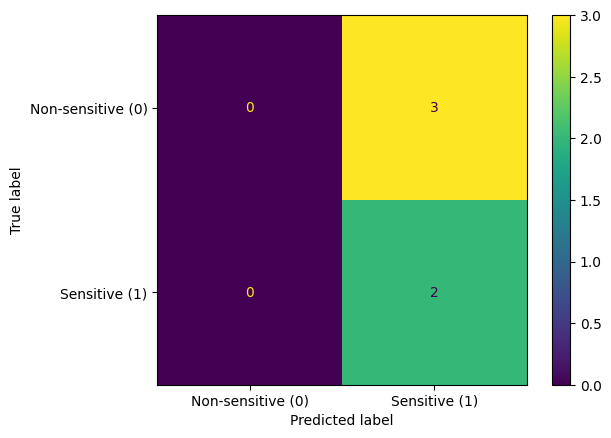

{'accuracy': 0.4, 'f1_score': 0.2285714285714286, 'balanced accuracy': 0.5}
["<s><s>  [INST] <<SYS>>\nYou are identifying documents containing personal sensitive information. Is the given text classified as 'sensitive' or 'non-sensitive'? You must answer with a the class inside a Python list and provide an explanation for your decision.\n<<SYS>>\n\nText: Call at 5:00 today (3:00 your time), if you can [/INST] \n\nClass: Non-sensitive\n\nExplanation: This text does not contain any personal sensitive information such as names, addresses, phone numbers, or financial information. It is a simple appointment"]
["<s><s>  [INST] <<SYS>>\nYou are identifying documents containing personal sensitive information. Is the given text classified as 'sensitive' or 'non-sensitive'? You must answer with a the class inside a Python list and provide an explanation for your decision.\n<<SYS>>\n\nText:  Steve Good news [/INST] \n\nClass: non-sensitive\n\nExplanation: The text provided does not contain any pe

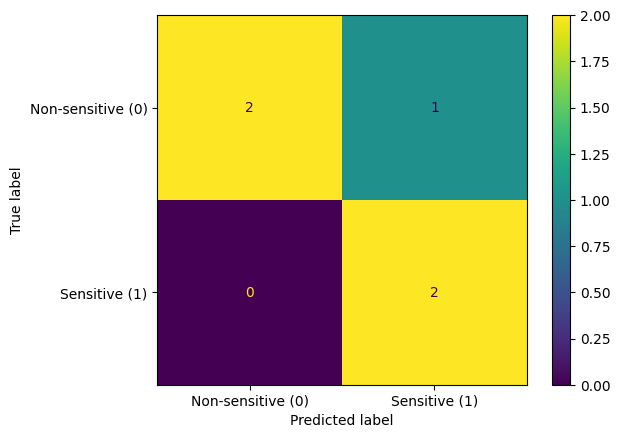

{'accuracy': 0.8, 'f1_score': 0.8, 'balanced accuracy': 0.8333333333333333}


In [19]:
mr = main_experiment('n', 5, 'replies_nometa', 'get_llama2', "meta-llama/Llama-2-7b-chat-hf", b1, '[/INST]', tokenizer, model)
mrexp = main_experiment('n', 5, 'replies_nometa', 'get_llama2', "meta-llama/Llama-2-7b-chat-hf", b1exp, '[/INST]', tokenizer, model)


In [37]:
def b1_2exp(document):
  return f"<s> [INST] You have expert knowledge about PII from the GDPR and you want to identify documents containing sensitive personal information. Is the given document sensitive or non-sensitive? You must answer with a class inside a Python list and provide an explanation for your decision.\nText: {document} \n [/INST] ["

def b1_2exp2(document):
  return f"<s> [INST] Adopt the role of an expert sensitivity reviewer that has knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. Is the given text sensitive or non-sensitive? You must answer first with the sensitive or non-sensitive inside a Python list, then provide an explanation for your decision.\nText: {document} \n [/INST] ["

In [38]:
mr = main_experiment('n', 2, 'replies_nometa', 'get_llama2', "meta-llama/Llama-2-7b-chat-hf", b1_2exp, '[/INST]', tokenizer, model)

['<s><s>  [INST] You have expert knowledge about PII from the GDPR and you want to identify documents containing sensitive personal information. Is the given document sensitive or non-sensitive? You must answer with a class inside a Python list and provide an explanation for your decision.\nText: Call at 5:00 today (3:00 your time), if you can \n [/INST] [INST: You have expert knowledge about PII from the GDPR and you want to identify documents containing sensitive personal information. Is the given document sensitive or non-sensitive? You must answer with']
["<s><s>  [INST] You have expert knowledge about PII from the GDPR and you want to identify documents containing sensitive personal information. Is the given document sensitive or non-sensitive? You must answer with a class inside a Python list and provide an explanation for your decision.\nText:  Steve Good news \n [/INST] [I'm just an AI, I don't have personal opinions or beliefs, and I must follow ethical guidelines to ensure a 

ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

SPACY - we investigated using spacy briefly as a preprocessing tool.

In [15]:
#!pip install spacy
#!python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")

In [34]:
sara_dataset = get_sara()
sara_df = dataset_to_df(sara_dataset)
for d in sara_df.text:
    print(d)
    doc = nlp(d)
    cleaned_text = " ".join(token.lemma_ for token in doc if not token.is_punct and not token.is_stop)
    print(cleaned_text)
    break

In [43]:
def b1_2(document):
  return f"<s> [INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. Is the given text sensitive or non-sensitive? You must answer with a Python list containing only the appropriate class, then provide an explanation, for example ['sensitive'] or ['non-sensitive'] then Explanation:. \nText: {document} \n [/INST] "

def b1(document):
  return f"<s> [INST] You are identifying documents containing personal sensitive information. Is the given text classified as 'sensitive' or 'non-sensitive'? You must answer with a the class inside a Python list and provide an explanation for your decision.\nText: {document} [/INST] \n"


def llm_inference(document, prompt, model, tokenizer):
    encodeds = tokenizer(prompt(document), return_tensors="pt")

    device = 'cuda'
    model_inputs = encodeds.to(device)
    generated_ids = model.generate(inputs=model_inputs.input_ids, attention_mask=model_inputs.attention_mask, max_new_tokens=40, do_sample=True) #, top_k=40, num_beams=4, temperature=0.7, top_p=0.95)
    decoded = tokenizer.batch_decode(generated_ids)

    del model_inputs
    torch.cuda.empty_cache()
    gc.collect()
    decoded = decoded[0]
    #print(decoded[decoded.find('[/INST]'):])
    return decoded[decoded.find('[/INST]'):]

In [46]:
i = 0
for d in sara_df.text:
    print('para', i)
    pred_d = llm_inference(d, b1_2, model, tokenizer)
    doc = nlp(d)
    cleaned_text = " ".join(token.lemma_ for token in doc if not token.is_punct and not token.is_stop)
    pred_clean = llm_inference(cleaned_text, b1_2, model, tokenizer)
    print(d)
    print(pred_d)
    print(cleaned_text)
    print(pred_clean)
    i += 1
    if i > 10:
        break

para 0
Though I had a somewhat different notion when I initially raised the idea of co-sponsorship, I agree with Lee's observations and think that we should proceed the way he suggests.
[/INST]  ['non-sensitive']</s>
somewhat different notion initially raise idea co sponsorship agree Lee observation think proceed way suggest
[/INST]  ['non-sensitive']</s>
para 1
 All, Lee asked me to forward this. I'm still awaiting additional suggestions from anyone on speakers.
[/INST]  ['non-sensitive']</s>
  Lee ask forward await additional suggestion speaker
[/INST]  ['non-sensitive']</s>
para 2
I guess Lee's e-mail changes things. If the business school wants to go forward with a conference anyway then it may be a bad idea to have a separate one. Jeff has said he likes the idea of coordinating. Bill and Allen, what do you think? I will chime in that Carl Shapiro is very much a big wig, as a former chief economist at DOJ. As for the Frank Wolak suggestion, Frank is a Stanford economist who is an o

In [ ]:
i = 0
for d in sara_df.text:
    print('para', i)
    doc = nlp(d)
    cleaned_text = " ".join(token.lemma_ for token in doc if not token.is_punct and not token.is_stop)        
    anonymized_text = d
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            anonymized_text = anonymized_text.replace(ent.text, "<PERSON>")
        elif ent.label_ == "GPE":
            anonymized_text = anonymized_text.replace(ent.text, "<LOCATION>")

    print(anonymized_text)

    break

We also tried the 70B quantised model with our new small chunks (1000 tokens). Note these important cells are copied from another notebook.

In [ ]:
def b1_2(document):
  return f"[INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. Classify the following document as either sensitive or non-sensitive. You must answer with a Python list, for example ['sensitive'] or ['non-sensitive'], and provide no further explanation. \Document: {document} [/INST] \nClassification: ["

def b1_2(document):
  return f"[INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. Classify the following document as either sensitive or non-sensitive. You must answer with a Python list, for example ['sensitive'] or ['non-sensitive'], and provide an explanation for your decision. \Document: {document} [/INST] \nClassification: ["

def llm_inference(document, prompt, model, tokenizer):
    encodeds = tokenizer(prompt(document), return_tensors="pt")
    device = 'cuda'
    model_inputs = encodeds.to(device)
    generated_ids = model.generate(inputs=model_inputs.input_ids, attention_mask=model_inputs.attention_mask, max_new_tokens=40, do_sample=True) #, top_k=40, num_beams=4, temperature=0.7, top_p=0.95)
    decoded = tokenizer.batch_decode(generated_ids)

    del model_inputs
    torch.cuda.empty_cache()
    gc.collect()
    dec = decoded[0]
    deci = dec.find('[/INST]')
    print(dec[deci:])
    return decoded[0]

[/INST] 
Classification: [non-sensitive]

Explanation:

This document does not contain any personal identifiable information (PII) as defined by the GDPR. The names mentioned in the
[/INST] 
Classification: [sensitive]
This document is sensitive as it contains the following personal information: Phone number, fax number, email, and mailing address. Even though the name "Kevin" is only
[/INST] 
Classification: [non-sensitive]

Explanation:
This email exchange between Philip Annesley and Vince Kaminski does not contain any sensitive personal information (PII) as defined by
[/INST] 
Classification: [sensitive]

Explanation:

This document contains sensitive personal information, specifically the email address <pannesley@riskwaters.com> and the phone number +44
[/INST] 
Classification: [sensitive]

Explanation:

The document at the provided URL, risk2001aus.com, appears to contain information related to the Risk 200
[/INST] 
Classification: [non-sensitive]

Explanation:

The document conta

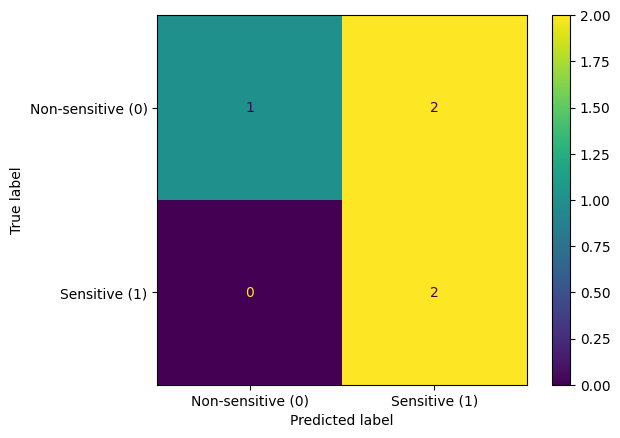

{'accuracy': 0.6, 'f1_score': 0.5666666666666667, 'balanced accuracy': 0.6666666666666666}


In [ ]:
m = 'get_llama2'
v = "TheBloke/Llama-2-70B-chat-GPTQ"
tokenizer, model = get_model_version(m, v)
mr = main_experiment('n', 5, 'replies_nometa', 'get_llama2', "meta-llama/Llama-2-7b-chat-hf", b1_2, '[/INST]', tokenizer, model)


In [ ]:
mr

{'177860_0': '[/INST] \nClassification: [non-sensitive]\n\nExplanation:\n\nThis document does not contain any personal identifiable information (PII) as defined by the GDPR. The names mentioned in the',
 '177860_1': '[/INST] \nClassification: [sensitive]\nThis document is sensitive as it contains the following personal information: Phone number, fax number, email, and mailing address. Even though the name "Kevin" is only',
 '54263_0': '[/INST] \nClassification: [non-sensitive]\n\nExplanation:\nThis email exchange between Philip Annesley and Vince Kaminski does not contain any sensitive personal information (PII) as defined by',
 '54263_1': '[/INST] \nClassification: [sensitive]\n\nExplanation:\n\nThis document contains sensitive personal information, specifically the email address <pannesley@riskwaters.com> and the phone number +44',
 '54263_2': '[/INST] \nClassification: [sensitive]\n\nExplanation:\n\nThe document at the provided URL, risk2001aus.com, appears to contain information re

### Other Prompt families

We were also interested in keeping documents non-segmented. This is because we could produce a more fair comparison against SVMs. We also see from using segmented documents with SVMs BAC performance is bad, similar to these models.

In [17]:
sara_dataset = get_sara()
sara_df = dataset_to_df(sara_dataset)

doc_lengths = sara_df.text.str.len()
long_docs = sara_df[doc_lengths > 5000]

print(len(long_docs))

drop = []
for r in sara_df.iterrows():
    idx = (r[0])
    tokens = tokenizer(bb(r[1].text))
    #print(len(tokens.input_ids))

    if len(tokens.input_ids) > 4050:
        drop.append(idx)
        #break

test = sara_df.drop(drop)
t = test.sample(n=30)
#t

258


In [21]:
def llm_inference(document, prompt, model, tokenizer):
    encodeds = tokenizer(prompt(document), return_tensors="pt")
    device = 'cuda'
    model_inputs = encodeds.to(device)
    generated_ids = model.generate(inputs=model_inputs.input_ids, attention_mask=model_inputs.attention_mask, max_new_tokens=10, do_sample=True) #, top_k=40, num_beams=4, temperature=0.7, top_p=0.95)
    decoded = tokenizer.batch_decode(generated_ids)

    del model_inputs
    torch.cuda.empty_cache()
    gc.collect()
    return decoded[0]

In [22]:
def cat(text):
    l = text.split('\r\n\r\n')
    return l[1]

#t['text'] = t['text'].apply(cat)

In [23]:
# Keep header
def bb(document):
  return f"[INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. Classify the contents of the following email thread document as either sensitive or non-sensitive. You must answer with a Python list, for example ['sensitive'] or ['non-sensitive'], and provide no further explanation. \nDocument: {document} [/INST] \nClassification: ["
# Is the same function - but do it without header
def bb(document):
  return f"[INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. Classify the contents of the following email thread document as either sensitive or non-sensitive. You must answer with a Python list, for example ['sensitive'] or ['non-sensitive'], and provide no further explanation. \nDocument: {document} [/INST] \nClassification: ["

# CoT
def bb(document):
  return f"[INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. \nDocument: {document} \n\nClassify the above document as either sensitive or non-sensitive. You must answer with a Python list, for example ['sensitive'] or ['non-sensitive'], and provide no further explanation. Lets think step by step. \nDocument: {document} [/INST] \nClassification: ["

# Not requiring python list
def bb(document):
  return f"[INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. \nDocument: {document} \n\nClassify the document as either sensitive or non-sensitive. You must answer after 'Classification', and provide no further explanation. [/INST] \nClassification: "

{'174377': '[/INST] \nClassification:  Non-sensitive</s>', '174247': '[/INST] \nClassification:  Non-sensitive</s>', '54619': '[/INST] \nClassification:  Sensitive</s>', '175571': '[/INST] \nClassification:  Sensitive\n\nThe document contains personal information', '175086': '[/INST] \nClassification:  Non-sensitive</s>', '136415': '[/INST] \nClassification:  Sensitive</s>', '174052': '[/INST] \nClassification:  Non-sensitive\n\nThe document contains information', '173411': '[/INST] \nClassification:  Non-sensitive</s>', '54580': '[/INST] \nClassification:  Sensitive\n\nThe document contains personal information', '176853': '[/INST] \nClassification:  Non-sensitive</s>', '232647': '[/INST] \nClassification:  Sensitive</s>', '133156': '[/INST] \nClassification:  Sensitive</s>', '173158': '[/INST] \nClassification:  Non-sensitive</s>', '150183': '[/INST] \nClassification:  Non-sensitive</s>', '175983': '[/INST] \nClassification:  Sensitive</s>', '122737': '[/INST] \nClassification:  Non-

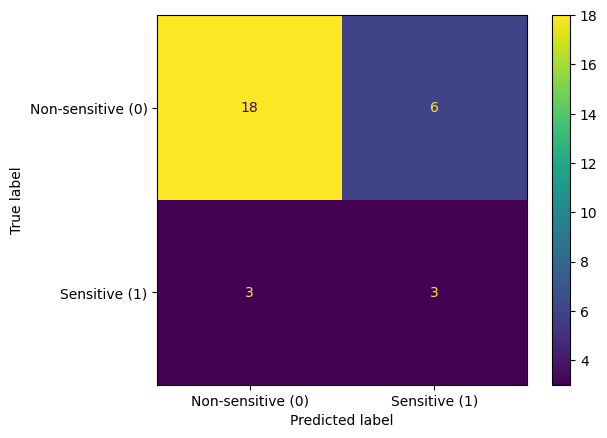

{'accuracy': 0.7, 'f1_score': 0.7200000000000001, 'balanced accuracy': 0.625}


In [55]:

predictions, further_processing_required, model_responses, truths, preds = llm_experiment(t, bb, model, tokenizer, '[/INST] \nC')
new_preds, new_truths = post_process_split_docs(model_responses, further_processing_required, preds, sara_df)
print(model_responses)
evaluation_summary("Llama-2", new_truths, new_preds)
get_metric_dict("Llama-2", new_truths, new_preds)

In [56]:
model_responses

{'174377': '[/INST] \nClassification:  Non-sensitive</s>',
 '174247': '[/INST] \nClassification:  Non-sensitive</s>',
 '54619': '[/INST] \nClassification:  Sensitive</s>',
 '175571': '[/INST] \nClassification:  Sensitive\n\nThe document contains personal information',
 '175086': '[/INST] \nClassification:  Non-sensitive</s>',
 '136415': '[/INST] \nClassification:  Sensitive</s>',
 '174052': '[/INST] \nClassification:  Non-sensitive\n\nThe document contains information',
 '173411': '[/INST] \nClassification:  Non-sensitive</s>',
 '54580': '[/INST] \nClassification:  Sensitive\n\nThe document contains personal information',
 '176853': '[/INST] \nClassification:  Non-sensitive</s>',
 '232647': '[/INST] \nClassification:  Sensitive</s>',
 '133156': '[/INST] \nClassification:  Sensitive</s>',
 '173158': '[/INST] \nClassification:  Non-sensitive</s>',
 '150183': '[/INST] \nClassification:  Non-sensitive</s>',
 '175983': '[/INST] \nClassification:  Sensitive</s>',
 '122737': '[/INST] \nClassi

Introducing a ranking 1-10 for how sensitive a document is. This could be used as a threshold.

In [ ]:
len('[/INST] \nClassification: ')

In [33]:
def post_process_classification(classification, ground_truth):

    numb = classification[25]
    if numb == '1':
        if classification[26] == '0':
            numb = '10'

    if numb.isdigit():
        val = int(numb)
    else:
        val = 0

    if val <= 3:
        if ground_truth == 0:
            return 'TN', 0
        else:
            return 'FN', 0

    elif val >= 4:
        if ground_truth == 1:
            return 'TP', 1
        else:
            return 'FP', 1

    else:
        # Further processing required
        return classification, None
        further_processing_required[sample[1].doc_id] = classification

In [34]:
def bb(document):
  return f"[INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. \nDocument: {document} \n\nClassify the document as either sensitive or non-sensitive. You must answer after 'Classification', and provide no further explanation. [/INST] \nClassification:"


def bb(document):
  return f"[INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. \nDocument: {document} \n\nClassify the document as either sensitive or non-sensitive. You must answer on a scale of 1-10 for how sensitive a document is, where 1 is non-sensitive and 10 is very sensitive. [/INST] \nClassification:"

def bb(document):
  return f"[INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. Classify the document as either sensitive or non-sensitive. You must answer on a scale of 1-10 for how sensitive a document is, where 1 is non-sensitive and 10 is very sensitive. \nDocument: {document} [/INST] \nClassification:"

In [57]:
# Where doc is the first document in t
v = llm_inference(doc, bb, model, tokenizer)
v

"<s> [INST] You are an expert sensitivity reviewer with knowledge about PII from the GDPR. We want to identify documents containing sensitive personal information to protect them. \nDocument: According to this morning's Washington Post, the Bush Administration will \nsupport the expected FERC action today of extending the existing California \nprice mitigation regime to 10 other Western states and to all days/all hours, \nnot just during California emergencies (stages 1, 2 and 3).  This action \ncomes only a day before FERC and other witnesses will  testify on the \nFeinstein/Smith price cap legislation before the Senate Energy Committee, \nGov. Davis and FERC will  testify before the Senate Governmental Affairs \nCommittee on Wednesday, and the House Financial Services Committee joins the \nfray with a hearing on the California energy situation on Wednesday.  The \nlatter committee will probably base its jurisdiction over some aspect of \nenergy policy on a number of factors, includin

In [ ]:
t = test.sample(n=10, random_state=1)
t['text'] = t['text'].apply(cat)

{'176659': '[/INST] \nClassification: Non-sensitive (level 1)\n', '175838': '[/INST] \nClassification: 5/10 (Moderately S', '175162': '[/INST] \nClassification: Non-sensitive (level 1)\n', '177808': '[/INST] \nClassification: 4/10\n\nReasons:', '173216': '[/INST] \nClassification: 6 out of 10\n\nThe', '55071': '[/INST] \nClassification: Sensitivity level 7 (out of ', '173218': '[/INST] \nClassification: Non-Sensitive, Level 1\n', '174196': '[/INST] \nClassification: Sensitivity Level 4\n\nThis is', '54616': '[/INST] \nClassification: Sensitivity Level 4 (Moderately', '175160': '[/INST] \nClassification: Non-sensitive (scale rank 3)'}
Evaluation for: Llama-2
                   precision    recall  f1-score   support

Non-sensitive (0)      0.714     0.625     0.667         8
    Sensitive (1)      0.000     0.000     0.000         2

         accuracy                          0.500        10
        macro avg      0.357     0.312     0.333        10
     weighted avg      0.571     0.50

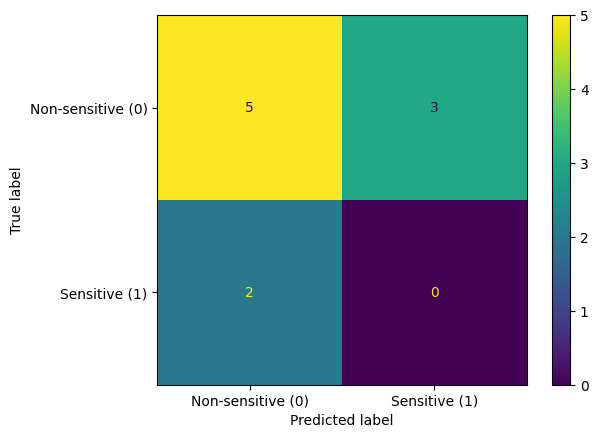

{'accuracy': 0.5, 'f1_score': 0.5333333333333333, 'balanced accuracy': 0.3125}


In [35]:

predictions, further_processing_required, model_responses, truths, preds = llm_experiment(t, bb, model, tokenizer, '[/INST] \nC')
new_preds, new_truths = post_process_split_docs(model_responses, further_processing_required, preds, sara_df)
print(model_responses)
evaluation_summary("Llama-2", new_truths, new_preds)
get_metric_dict("Llama-2", new_truths, new_preds)

In [37]:
model_responses

{'176659': '[/INST] \nClassification: Non-sensitive (level 1)\n',
 '175838': '[/INST] \nClassification: 5/10 (Moderately S',
 '175162': '[/INST] \nClassification: Non-sensitive (level 1)\n',
 '177808': '[/INST] \nClassification: 4/10\n\nReasons:',
 '173216': '[/INST] \nClassification: 6 out of 10\n\nThe',
 '55071': '[/INST] \nClassification: Sensitivity level 7 (out of ',
 '173218': '[/INST] \nClassification: Non-Sensitive, Level 1\n',
 '174196': '[/INST] \nClassification: Sensitivity Level 4\n\nThis is',
 '54616': '[/INST] \nClassification: Sensitivity Level 4 (Moderately',
 '175160': '[/INST] \nClassification: Non-sensitive (scale rank 3)'}

With llama 2 we have the above response to scoring sensitivity, below is Mistral's response.

In [ ]:
cv = t.doc_id[t.sensitivity == 1]
cv

In [78]:
x = cv.to_list()
c = 0
for k in x:
    print(model_responses[k])
    c += 1

print(c)

[/INST] 
Classification: 5 

Reasoning: 

[/INST] 
Classification: 3 (Moderately Sensitive) 
[/INST] 
Classification: 4

This document does mention a specific
[/INST] 
Classification: 5

Reasoning: 


[/INST] 
Classification: 1 

Reasoning: 

[/INST] 
Classification: 1 (Non-Sensitive) 

[/INST] 
Classification: This document is rated as 1 on a sensitivity
[/INST] 
Classification: 1 (Non-sensitive)


[/INST] 
Classification: I would rate this document as a 1 out
[/INST] 
Classification: 1 (Non-sensitive)


[/INST] 
Classification: 2 

The document "Western
[/INST] 
Classification: 1 (low sensitivity) 

The
[/INST] 
Classification: 1 (Non-sensitive)


13
